In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from torch.linalg import norm
from sklearn.linear_model import LinearRegression
from MODULE_dataset import AdSBHDataset
from MODULE_model import AdSBHNet
from constants import dreal, dcomplex

ModuleNotFoundError: No module named 'MODULE_dataset'

**This notebook can be run from top to bottom so that for each temperature, you just change the parameters of the very first cell below. You do not need to change anything else, or edit any of the other cells. Run all the cells. The training cell takes about 25mins for 1000 epoch to run.**

# Import dataset

**Change these to import different temperatures, and modify how many terms in a, b you want. You don't need to edit anything else in the notebook to run different T**

In [2]:
#------------------------------------------------------------------------------------------#
# Put here the dataset file, temperature and number of terms for a and b polynomials (N)
dataset = AdSBHDataset(file='1607latticeT406.txt')
T= 406
N = 3
#------------------------------------------------------------------------------------------#

Mask the data to use L <1.4 points, and plot (we are now only interested in the real data)

Dataset: 14 points
L range: [0.1845, 1.3971]


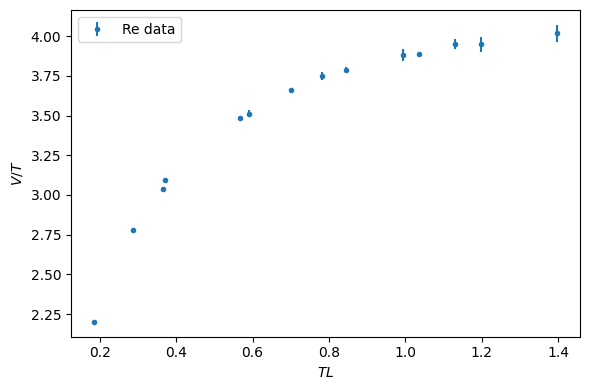

In [3]:
mask_L = dataset.L < 1.4
L_all     = dataset.L[mask_L]
V_all     = dataset.V[mask_L]
sigma_all = dataset.sigma[mask_L]

print(f"Dataset: {len(L_all)} points")
print(f"L range: [{L_all.min():.4f}, {L_all.max():.4f}]")

plt.figure(figsize=(6,4))
plt.errorbar(L_all.numpy(), V_all.real.numpy(),
             yerr=sigma_all.real.numpy(), fmt='.', label='Re data')
plt.xlabel(r'$T L$'); plt.ylabel(r'$V/T$'); plt.legend(); plt.tight_layout()

Here we have the imaginary part too, but we won't use it

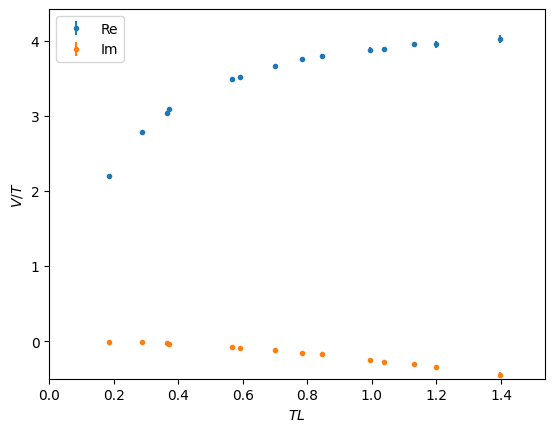

In [4]:
dataset.V = dataset.V[dataset.L < 1.4]
dataset.sigma = dataset.sigma[dataset.L < 1.4]
dataset.L = dataset.L[dataset.L < 1.4]
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

Set up the model

In [5]:
model = AdSBHNet(N=N, std=0.5)
device = L_all.device
model.to(device)

# start from AdS–BH but enforce a0=-b0<0 and modest magnitude
with torch.no_grad():
    model.a.zero_()
    model.b.zero_()
    init_a0 = -0.3
    model.a[0] = init_a0
    model.b[0] = -init_a0
    model.logcoef.fill_(0.0)   
    model.shift.fill_(0.0)    

print("Initial parameters:")
print("  a =", model.a.detach().cpu().numpy())
print("  b =", model.b.detach().cpu().numpy())
print(f"  coef = {model.logcoef.exp().item():.3f}, shift = {model.shift.item():.3f}")


Initial parameters:
  a = [-0.3  0.   0. ]
  b = [0.3 0.  0. ]
  coef = 1.000, shift = 0.000


# Helper functions

In [6]:
def connected_branch(model, zmin=0.02, zmax=0.9995, Nc=2500):
    dev, dt = model.a.device, model.a.dtype
    zs = torch.linspace(zmin, zmax, Nc, dtype=dt, device=dev)
    Lc = model.integrate_L(zs).real
    Vc = model.logcoef.exp() * model.integrate_V(zs).real
    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]
    imax = torch.argmax(Lc)
    return Lc[:imax+1], Vc[:imax+1]


def V_of_L_interp_real(model, L_query,
                       zmin=0.02, zmax=0.9997, zs_num=4000, q=2.7, eps=1e-12):
    dev, dt = model.a.device, model.a.dtype
    Lq = torch.as_tensor(L_query, dtype=dt, device=dev).reshape(-1)

    u  = torch.linspace(0.0, 1.0, zs_num, dtype=dt, device=dev)
    zs = zmin + (zmax - zmin) * (u**q)

    Lc = model.integrate_L(zs).real
    Vc = model.logcoef.exp() * model.integrate_V(zs).real

    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]

    dL = torch.diff(Lc)
    keep = torch.cat([torch.tensor([True], device=dev), dL > 0])
    Lm, Vm = Lc[keep], Vc[keep]

    if Lm.numel() < 2:
        Lm, Vm = Lc, Vc

    pos = torch.searchsorted(Lm, Lq, right=True)
    i0 = (pos-1).clamp(0, Lm.numel()-2)
    i1 = i0+1
    x0, x1 = Lm[i0], Lm[i1]
    y0, y1 = Vm[i0], Vm[i1]

    w     = (Lq - x0) / (x1 - x0 + eps)
    v_lin = y0 + w*(y1-y0)

    mL = (Vm[1]-Vm[0])   / (Lm[1]-Lm[0]   + eps)
    mR = (Vm[-1]-Vm[-2]) / (Lm[-1]-Lm[-2] + eps)

    v_left  = Vm[0]  + mL*(Lq - Lm[0])
    v_right = Vm[-1] + mR*(Lq - Lm[-1])

    v = torch.where(Lq <  Lm[0],  v_left,  v_lin)
    v = torch.where(Lq >  Lm[-1], v_right, v)

    return v, (Lm[0].detach(), Lm[-1].detach())


def smoothness_C2(val_fn, z):
    v = val_fn(z)
    d2 = v[:-2] - 2*v[1:-1] + v[2:]
    return (d2.real**2).mean()


def uv_horizon_penalty(model):
    z0 = torch.tensor(1e-3,  dtype=model.a.dtype, device=model.a.device)
    zh = torch.tensor(0.995, dtype=model.a.dtype, device=model.a.device)

    f0   = model.eval_f(z0)
    g0   = model.eval_g(z0)
    fhor = model.eval_f(zh)

    def _r2(t, target):
        if torch.is_complex(t):
            return (t.real - target)**2 + t.imag**2
        else:
            return (t - target)**2

    return _r2(f0, 1.0) + _r2(g0, 1.0) + _r2(fhor, 0.0)

def swallowtail_reg(current_model, z_grid, L0_ref, V0_ref,
                    alpha_L=1.0, alpha_V=0.3):
    """
    Penalize deviations of the real parametric curve (L(z*), V(z*)) from
    the reference AdS–BH swallowtail.

    alpha_L: relative weight on matching L(z*)
    alpha_V: relative weight on matching V(z*)
    """
    Lc = current_model.integrate_L(z_grid).real
    Vc = current_model.logcoef.exp() * current_model.integrate_V(z_grid).real

    loss_L = ((Lc - L0_ref)**2).mean()
    loss_V = ((Vc - V0_ref)**2).mean()

    return alpha_L * loss_L + alpha_V * loss_V


def nec_penalty(model, num_samples=100, weight=100.0):
    """
    Compute NEC (Null Energy Condition) violation penalty.
    
    NEC requires: -(3/2z) * [a'(z) + b'(z)] >= 0 for all z in [0, 1]
    This means: (a0+b0) + 2(a1+b1)z + 3(a2+b2)z^2 + 4(a3+b3)z^3 <= 0
    
    We penalize violations where P(z) > 0.
    
    Args:
        model: The AdSBHNet model
        num_samples: Number of z points to check
        weight: Multiplier for the penalty (default 100.0)
    
    Returns:
        Weighted penalty value (tensor)
    """
    a = model.a
    b = model.b
    device = a.device
    dtype = a.dtype
    
    z = torch.linspace(0.01, 0.99, num_samples, dtype=dtype, device=device)
    
    # Compute polynomial P(z) = sum (n+1)(an+bn)z^n
    P = (a[0] + b[0]) + 2*(a[1] + b[1])*z + 3*(a[2] + b[2])*z**2 + 4*(a[3] + b[3])*z**3
    
    # NEC violation if P > 0
    violation = torch.relu(P).max()
    
    return weight * violation

# Initialization 

In [7]:
from sklearn.linear_model import LinearRegression

with torch.no_grad():
    Lm, Vm = connected_branch(model)
    Ld = L_all.to(device=Lm.device, dtype=Lm.dtype)
    Vd = V_all.real.to(device=Lm.device, dtype=Lm.dtype)

    mask = (Ld >= Lm[0]) & (Ld <= Lm[-1])
    L_fit = Ld[mask]
    Y_fit = Vd[mask]

    # model V at those L (via interpolation)
    def _interp_1d(x, y, xq, eps=1e-12):
        dt, dev = x.dtype, x.device
        xq = torch.as_tensor(xq, dtype=dt, device=dev).reshape(-1)
        pos = torch.searchsorted(x, xq, right=True)
        i0 = (pos-1).clamp(0, x.numel()-2); i1 = i0+1
        x0, x1 = x[i0], x[i1]; y0, y1 = y[i0], y[i1]
        w  = (xq - x0) / (x1 - x0 + eps)
        v_lin = y0 + w*(y1-y0)
        mL = (y[1]-y[0])/(x[1]-x[0]+eps)
        mR = (y[-1]-y[-2])/(x[-1]-x[-2]+eps)
        v_left  = y[0]  + mL*(xq - x[0])
        v_right = y[-1] + mR*(xq - x[-1])
        v = torch.where(xq <  x[0],  v_left,  v_lin)
        v = torch.where(xq >  x[-1], v_right, v)
        return v

    X_fit = _interp_1d(Lm, Vm, L_fit) / model.logcoef.exp()

    fit = LinearRegression().fit(X_fit.cpu().numpy().reshape(-1,1),
                                 Y_fit.cpu().numpy())
    slope = max(float(fit.coef_[0]), 1e-12)
    shift = float(fit.intercept_)

    model.logcoef = nn.Parameter(torch.tensor(np.log(slope),
                                              dtype=model.a.dtype,
                                              device=model.a.device))
    model.shift   = nn.Parameter(torch.tensor(shift,
                                              dtype=model.a.dtype,
                                              device=model.a.device))

print(f"LS init: coef = {model.logcoef.exp().item():.3f}, shift = {model.shift.item():.3f}")

LS init: coef = 0.307, shift = 4.636


# Loss function

In [8]:
eps = 1e-12
dev, dt = model.a.device, model.a.dtype
def compute_Lmax(model, zmin=0.02, zmax=0.995, Nc=2000):
    """Compute the maximum L value on the real branch."""
    dev, dt = model.a.device, model.a.dtype
    with torch.no_grad():
        try:
            zs = torch.linspace(zmin, zmax, Nc, dtype=dt, device=dev)
            Lc = model.integrate_L(zs).real
            if not torch.isfinite(Lc).all():
                return torch.tensor(0.4, device=dev, dtype=dt)  # Return reasonable default
            Lmax = Lc.max()
            if Lmax < 0.1:  # Too small
                return torch.tensor(0.4, device=dev, dtype=dt)
            return Lmax
        except:
            return torch.tensor(0.4, device=dev, dtype=dt)


def nec_penalty_simple(model, num_samples=100):
    """
    NEC penalty: penalize where d(a+b)/dz > 0
    For polynomials: a(z) = a0*z + a1*z^2 + ..., b(z) = b0*z + b1*z^2 + ...
    d(a+b)/dz = (a0+b0) + 2(a1+b1)z + 3(a2+b2)z^2 + ...
    """
    z = torch.linspace(1e-3, 0.98, num_samples, dtype=model.a.dtype, device=model.a.device)

    # Compute derivative
    N = model.a.numel()
    deriv = torch.zeros_like(z)
    for i in range(N):
        deriv = deriv + (i + 1) * (model.a[i] + model.b[i]) * (z ** i)

    # NEC violation when derivative > 0
    violation = torch.relu(deriv).mean()
    return violation


def monotonicity_penalty(model, num_samples=100):
    """
    Soft penalty for monotonicity: f(z)/z^4 should be decreasing.
    
    For f(z) = (1-z^4)·exp(a(z)), monotonicity requires:
        z·a'(z)·(1-z^4) < 4
    
    This is a SOFT constraint - we only penalize when severely violated.
    """
    device = model.a.device
    dtype = model.a.dtype
    
    z = torch.linspace(0.05, 0.95, num_samples, dtype=dtype, device=device)
    
    # Compute a'(z)
    a_prime = model.eval_da(z)
    
    # Monotonicity condition: z·a'(z)·(1-z^4) < 4
    lhs = z * a_prime * (1 - z**4)
    
    # Only penalize SEVERE violations (lhs > 5.0)
    # This gives the model room to explore while preventing crashes
    violation = torch.relu(lhs - 5.0)
    
    return violation.mean()


def compute_loss_physics(model, Lb, Vb, sb,
                        target_Lmax=0.5,
                        lam_data=1.0,
                        lam_Lmax=200.0,
                        lam_nec=10.0,
                        lam_a0b0=10.0,
                        lam_magnitude=1.0,
                        lam_monotonicity=10.0,
                        lam_reg=1e-3):
    """
    Physics-informed loss (works for arbitrary N):
      1. Fit data points on the STABLE branch (L < L_max)
      2. Penalize L_max deviation from target range [0.35, 0.7]
      3. Enforce NEC constraint
      4. Soft constraint: a0 + b0 ≈ 0
      5. Encourage non-trivial parameters (especially higher-order)
      6. Soft monotonicity penalty (gentle)
      7. Light L2 regularization to prevent explosion
    """
    dev, dt = model.a.device, model.a.dtype
    N = model.a.numel()  # Get actual number of parameters

    Lb = Lb.to(dev, dtype=dt)
    Vb = Vb.to(dev)
    sb = sb.to(dev)

    # Conservative clamping to prevent explosion (wider range)
    with torch.no_grad():
        model.a.clamp_(-2.5, 2.5)
        model.b.clamp_(-2.5, 2.5)
        model.logcoef.clamp_(-3.0, 1.0)
        model.shift.clamp_(-5.0, 15.0)

    try:
        # Compute L_max
        Lmax_val = compute_Lmax(model)

        # Penalty for L_max outside target range [0.35, 0.7]
        Lmax_penalty = torch.tensor(0.0, device=dev, dtype=dt)
        if Lmax_val < 0.35:
            Lmax_penalty = lam_Lmax * (0.35 - Lmax_val)**2
        elif Lmax_val > 0.7:
            Lmax_penalty = lam_Lmax * (Lmax_val - 0.7)**2

        # Soft constraint: a0 + b0 ≈ 0 (instead of hard constraint)
        a0b0_penalty = lam_a0b0 * (model.a[0] + model.b[0])**2

        # Encourage larger magnitude for highest-order terms (dynamically adapt to N)
        magnitude_penalty = torch.tensor(0.0, device=dev, dtype=dt)
        if N > 0:
            # Penalize if highest-order terms are too small
            last_idx = N - 1
            magnitude_penalty = lam_magnitude * (
                torch.relu(0.5 - model.a[last_idx].abs()) +  # penalize if |a[N-1]| < 0.5
                torch.relu(0.5 - model.b[last_idx].abs())     # penalize if |b[N-1]| < 0.5
            )

        # Get V predictions
        V_core, (Lmin, Lmax_interp) = V_of_L_interp_real(model, Lb, zs_num=2000)

        if not torch.isfinite(V_core).all():
            penalty = 1e4 + lam_reg * ((model.a**2).sum() + (model.b**2).sum())
            return penalty, {'error': 'V_core_nan', 'Lmax': float(Lmax_val.item())}

        # Only fit points on the STABLE branch: L < L_max
        # (Stable = monotonically increasing L with z*)
        mask = (Lb < Lmax_val) & (Lb >= Lmin)

        if mask.sum() < 2:
            # If insufficient points, use ALL points and add large Lmax penalty
            mask = torch.ones_like(Lb, dtype=torch.bool)
            Lmax_penalty = Lmax_penalty + 5000.0 * (0.5 - Lmax_val)**2  # Force larger Lmax
            if mask.sum() < 2:
                penalty = 1e3 + Lmax_penalty
                return penalty, {'error': 'no_data', 'Lmax': float(Lmax_val.item()), 'mask_count': 0}

        V_pred = V_core[mask] + model.shift
        V_true = Vb.real[mask]

        # Weighted MSE by error bars
        sigma = sb.real[mask]
        weights = 1.0 / (sigma**2 + eps)
        weights = weights / weights.sum()  # normalize

        data_loss = lam_data * (weights * (V_pred - V_true)**2).sum()

        # NEC penalty
        nec_loss = lam_nec * nec_penalty_simple(model)

        # Monotonicity penalty (gentle - only penalizes severe violations)
        mono_loss = lam_monotonicity * monotonicity_penalty(model, num_samples=50)

        # L2 regularization (light touch)
        reg = lam_reg * ((model.a**2).sum() + (model.b**2).sum())

        loss = data_loss + Lmax_penalty + nec_loss + a0b0_penalty + magnitude_penalty + mono_loss + reg

        if not torch.isfinite(loss):
            penalty = 1e4 + Lmax_penalty + a0b0_penalty + reg
            return penalty, {'error': 'loss_nan', 'Lmax': float(Lmax_val.item())}

        return loss, {
            'data_loss': float(data_loss.item()),
            'Lmax': float(Lmax_val.item()),
            'Lmax_penalty': float(Lmax_penalty.item()),
            'nec_loss': float(nec_loss.item()),
            'a0b0_penalty': float(a0b0_penalty.item()),
            'mag_penalty': float(magnitude_penalty.item()),
            'mono_loss': float(mono_loss.item()),
            'mask_count': int(mask.sum().item())
        }

    except Exception as e:
        penalty = 1e4 + lam_reg * ((model.a**2).sum() + (model.b**2).sum())
        return penalty, {'error': str(e)[:50], 'Lmax': 0.0}

# Training

**The training will take 22 minutes for N=3 and 25 minutes for N=4**

In [ ]:
device = model.a.device
dt     = model.a.dtype
eps    = 1e-12

model = AdSBHNet(N=N, std=0.1)
model.to(device)

# full dataset
L_all     = dataset.L.to(device=device, dtype=dt)
V_all     = dataset.V.to(device=device, dtype=torch.cdouble)
sigma_all = dataset.sigma.to(device=device, dtype=torch.cdouble)

# train/val split
N_tot = L_all.shape[0]
perm  = torch.randperm(N_tot, device=device)
n_val = max(4, int(0.2 * N_tot))
idx_val   = perm[:n_val]
idx_train = perm[n_val:]

L_train, V_train, sigma_train = L_all[idx_train], V_all[idx_train], sigma_all[idx_train]
L_val,   V_val,   sigma_val   = L_all[idx_val],   V_all[idx_val],   sigma_all[idx_val]

print(f"Training on {len(L_train)} points, validating on {len(L_val)} points")
print("This training will take about 25 minutes for 1000 epochs")
print(f"L_train range: [{L_train.min():.3f}, {L_train.max():.3f}]")
print(f"Model has N={N} parameters per polynomial")

torch.set_grad_enabled(True)

# Start with parameters that give larger L_max
with torch.no_grad():
    model.a.zero_()
    model.b.zero_()

    # 
    if T < 300:
        model.a[0] = -0.2
        model.b[0] = -0.1
    elif 300 < T < 350:
        model.a[0] = -0.15
        model.b[0] = -0.05
    elif T > 350:
        model.a[0] = -0.08  
        model.b[0] = -0.025

    # Higher-order terms 
    if N > 1:
        model.a[1:] = torch.abs(torch.randn(N-1, dtype=dt, device=device)) * 0.1 + 0.05
        model.b[1:] = torch.abs(torch.randn(N-1, dtype=dt, device=device)) * 0.1 + 0.05

    # Initialize logcoef and shift
    model.logcoef.fill_(np.log(0.20))
    model.shift.fill_(5.5)

print(f"Initial parameters:")
print(f"  a = {model.a.detach().cpu().numpy()}")
print(f"  b = {model.b.detach().cpu().numpy()}")
print(f"  Check: a[0]={model.a[0].item():.4f} < b[0]={model.b[0].item():.4f} < 0? {model.a[0].item() < model.b[0].item() < 0}")
print(f"  coef = {model.logcoef.exp().item():.3f}, shift = {model.shift.item():.3f}")

# Check initial Lmax
with torch.no_grad():
    try:
        init_Lmax = compute_Lmax(model)
        print(f"  Initial L_max = {init_Lmax:.3f}")
    except Exception as e:
        print(f"  Could not compute initial L_max: {e}")

train_ds     = torch.utils.data.TensorDataset(L_train, V_train, sigma_train)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=len(L_train), shuffle=True)

# Optimizer
opt = torch.optim.Adam([
    {'params': [model.a],       'lr': 5e-3},
    {'params': [model.b],       'lr': 5e-3},
    {'params': [model.shift],   'lr': 5e-3},
    {'params': [model.logcoef], 'lr': 3e-3},
])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.7, patience=50)

EPOCHS = 1000
a_hist, b_hist = [], []
train_loss_hist, val_loss_hist = [], []
Lmax_hist = []

best_loss = float('inf')
best_state = None
prev_lr = opt.param_groups[0]['lr']


print("  Early epochs: PUSH parameters away from zero")
print("  Later epochs: Allow optimization to fine-tune\n")

nan_count = 0
max_nan_tolerance = 10

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0; n_batches = 0
    epoch_info = {}

    # bounds, staged
    if epoch <= 200:
        a0_min, a0_max = -0.2, -0.005
        b0_min, b0_max = -0.2, -0.002
        a0_target_mag = 0.1
        b0_target_mag = 0.05
    elif epoch <= 400:
        a0_min, a0_max = -0.4, -0.003
        b0_min, b0_max = -0.35, -0.001
        a0_target_mag = 0.15
        b0_target_mag = 0.08
    elif epoch <= 700:
        a0_min, a0_max = -0.6, -0.002
        b0_min, b0_max = -0.5, -0.001
        a0_target_mag = 0.2
        b0_target_mag = 0.1
    else:
        a0_min, a0_max = -0.8, -0.001
        b0_min, b0_max = -0.7, -0.0005
        a0_target_mag = 0.25
        b0_target_mag = 0.12

    # MAGNITUDE PENALTY schedule
    if epoch < 300:
        lam_mag_encourage = 20.0
    elif epoch < 600:
        lam_mag_encourage = 8.0
    else:
        lam_mag_encourage = 2.0

    # Standard magnitude penalty
    if epoch < 200:
        lam_magnitude_current = 3.0
    elif epoch < 400:
        lam_magnitude_current = 1.5
    else:
        lam_magnitude_current = 0.5

    # Lmax penalty
    if epoch < 300:
        lam_Lmax_current = 100.0
    elif epoch < 600:
        lam_Lmax_current = 200.0
    else:
        lam_Lmax_current = 300.0

    # Monotonicity penalty schedule, starts at 0
    if epoch < 100:
        lam_monotonicity_current = 0.0   # No penalty early on
    elif epoch < 300:
        lam_monotonicity_current = 5.0   # Very gentle
    elif epoch < 600:
        lam_monotonicity_current = 10.0  # Mild
    else:
        lam_monotonicity_current = 15.0  # Moderate

    for Lb, Vb, sb in train_loader:
        opt.zero_grad()

        try:
            loss, info = compute_loss_physics(model, Lb, Vb, sb,
                                              target_Lmax=0.5,
                                              lam_data=10.0,
                                              lam_Lmax=lam_Lmax_current,
                                              lam_nec=0.0,
                                              lam_a0b0=0.0,
                                              lam_magnitude=lam_magnitude_current,
                                              lam_monotonicity=lam_monotonicity_current,
                                              lam_reg=1e-3)

            if 'error' in info:
                print(f"Epoch {epoch}: {info['error']}, Lmax={info.get('Lmax', 0):.3f}")
                break

            # MAGNITUDE ENCOURAGEMENT (works for any N)
            mag_penalty = torch.tensor(0.0, device=device, dtype=dt)

            # Push a[0], b[0] to have magnitude >= target
            if model.a[0].abs() < a0_target_mag:
                mag_penalty += lam_mag_encourage * (a0_target_mag - model.a[0].abs())**2
            if model.b[0].abs() < b0_target_mag:
                mag_penalty += lam_mag_encourage * (b0_target_mag - model.b[0].abs())**2

            # Encourage higher-order terms (dynamically adapts to N)
            if N > 1:
                for i in range(1, N):
                    if model.a[i] < 0.05:
                        mag_penalty += 0.5 * lam_mag_encourage * (0.05 - model.a[i])**2
                    if model.b[i] < 0.05:
                        mag_penalty += 0.5 * lam_mag_encourage * (0.05 - model.b[i])**2

            loss = loss + mag_penalty

            # Check for NaN
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Epoch {epoch}: NaN/Inf loss detected!")
                nan_count += 1
                if nan_count > max_nan_tolerance:
                    print("Too many NaNs - stopping")
                    break
                continue

            loss.backward()

            # Check for nan gradients
            has_nan_grad = False
            for name, param in model.named_parameters():
                if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
                    print(f"Epoch {epoch}: NaN gradient in {name}")
                    has_nan_grad = True
                    break

            if has_nan_grad:
                nan_count += 1
                continue

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        except Exception as e:
            print(f"Epoch {epoch}: Exception: {e}")
            nan_count += 1
            if nan_count > max_nan_tolerance:
                break
            continue

        # constraints of a and b
        with torch.no_grad():
            # a[0] < b[0] < 0
            model.a[0].clamp_(a0_min, a0_max)
            model.b[0].clamp_(b0_min, b0_max)

            if model.a[0] >= model.b[0]:
                avg = (model.a[0] + model.b[0]) / 2.0
                model.a[0] = avg - 0.01
                model.b[0] = avg + 0.01
                model.a[0].clamp_(a0_min, a0_max)
                model.b[0].clamp_(b0_min, b0_max)

            # Higher-order terms > 0
            if N > 1:
                model.a[1:].clamp_(min=1e-5)
                model.b[1:].clamp_(min=1e-5)

            # Prevent explosion
            model.a.clamp_(-2.0, 2.0)
            model.b.clamp_(-2.0, 2.0)

        running += float(loss.item())
        n_batches += 1
        epoch_info = info
        epoch_info['mag_encourage'] = float(mag_penalty.item())

    if n_batches == 0 or nan_count > max_nan_tolerance:
        print(f"Training stopped at epoch {epoch}")
        break

    train_loss = running / max(n_batches, 1)
    scheduler.step(train_loss)

    # Check if learning rate was reduced
    current_lr = opt.param_groups[0]['lr']
    if current_lr < prev_lr:
        print(f"Epoch {epoch}: Reduced learning rate to {current_lr:.2e}")
        prev_lr = current_lr

    # Track best model
    if train_loss < best_loss and not torch.isnan(torch.tensor(train_loss)):
        best_loss = train_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    # validation
    model.eval()
    with torch.no_grad():
        try:
            val_loss, val_info = compute_loss_physics(model, L_val, V_val, sigma_val,
                                                      target_Lmax=0.5, lam_data=10.0,
                                                      lam_Lmax=lam_Lmax_current, lam_nec=0.0,
                                                      lam_a0b0=0.0, lam_magnitude=lam_magnitude_current,
                                                      lam_monotonicity=lam_monotonicity_current,
                                                      lam_reg=1e-3)
            loss_val = float(val_loss.item()) if torch.isfinite(val_loss) else float('nan')
        except:
            loss_val = float('nan')
            val_info = {}

    a_hist.append(model.a.detach().cpu().numpy().copy())
    b_hist.append(model.b.detach().cpu().numpy().copy())
    train_loss_hist.append(train_loss)
    val_loss_hist.append(loss_val)
    Lmax_hist.append(epoch_info.get('Lmax', 0.0))

    if epoch % 100 == 0 or epoch == 1 or epoch in [200, 400, 700]:
        mono_val = epoch_info.get('mono_loss', 0)
        print(f"epoch {epoch:4d} | loss={train_loss:.2e} | Lmax={epoch_info.get('Lmax', 0):.3f} | " +
              f"Lmax_pen={epoch_info.get('Lmax_penalty', 0):.1e} | mono={mono_val:.2e}")
        print(f"          | data={epoch_info.get('data_loss', 0):.2e} | " +
              f"mag_enc={epoch_info.get('mag_encourage', 0):.2e} (λ={lam_mag_encourage:.1f})")
        print(f"          | a={model.a.detach().cpu().numpy()}")
        print(f"          | b={model.b.detach().cpu().numpy()}")
        print(f"          | |a[0]|={model.a[0].abs().item():.3f} (target>{a0_target_mag:.2f}), " +
              f"|b[0]|={model.b[0].abs().item():.3f} (target>{b0_target_mag:.2f})")
        print(f"          | coef={model.logcoef.exp().item():.4f}, shift={model.shift.item():.4f}")

# Restore best model
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    print(f"\nRestored best model with loss={best_loss:.3e}")

print("\nFinal parameters:")
print(f"a = {model.a.detach().cpu().numpy()}")
print(f"b = {model.b.detach().cpu().numpy()}")
print(f"Magnitudes:")
print(f"  |a[0]| = {model.a[0].abs().item():.4f}")
print(f"  |b[0]| = {model.b[0].abs().item():.4f}")
if N > 1:
    print(f"  |a[N-1]| = {model.a[N-1].abs().item():.4f}")
    print(f"  |b[N-1]| = {model.b[N-1].abs().item():.4f}")
print(f"Constraint verification:")
print(f"  a[0] = {model.a[0].item():.6f}, b[0] = {model.b[0].item():.6f}")
print(f"  a[0] < b[0] < 0? {model.a[0].item() < model.b[0].item() < 0}")
if N > 1:
    print(f"  a[1:] > 0? {(model.a[1:] > 0).all().item()}")
    print(f"  b[1:] > 0? {(model.b[1:] > 0).all().item()}")
print(f"coef = {model.logcoef.exp().item():.4f}, shift = {model.shift.item():.4f}")

with torch.no_grad():
    try:
        final_Lmax = compute_Lmax(model)
        print(f"Final L_max = {final_Lmax:.4f}")
    except:
        print("Final L_max could not be computed")

Training on 10 points, validating on 4 points
This training will take about 25 minutes for 1000 epochs
L_train range: [0.185, 1.397]
Model has N=3 parameters per polynomial
Initial parameters:
  a = [-0.08        0.14615858  0.18915556]
  b = [-0.025       0.18476745  0.06257632]
  Check: a[0]=-0.0800 < b[0]=-0.0250 < 0? True
  coef = 0.200, shift = 5.500
  Initial L_max = 0.383
  Early epochs: PUSH parameters away from zero
  Later epochs: Allow optimization to fine-tune

epoch    1 | loss=2.52e+01 | Lmax=0.383 | Lmax_pen=0.0e+00 | mono=0.00e+00
          | data=2.29e+01 | mag_enc=2.05e-02 (λ=20.0)
          | a=[-0.085       0.14115858  0.19415555]
          | b=[-0.03        0.17976745  0.06757632]
          | |a[0]|=0.085 (target>0.10), |b[0]|=0.030 (target>0.05)
          | coef=0.2006, shift=5.4950
epoch  100 | loss=4.31e-03 | Lmax=0.406 | Lmax_pen=0.0e+00 | mono=0.00e+00
          | data=3.44e-03 | mag_enc=1.88e-04 (λ=20.0)
          | a=[-0.19751904  0.04602656  0.55254383]
   

# Visualization

L_max = 0.4128 at z* = 0.8912
Stable branch: 716 points, L range: [0.0235, 0.4128]
V range on stable branch: [-19.1160, 3.0812]


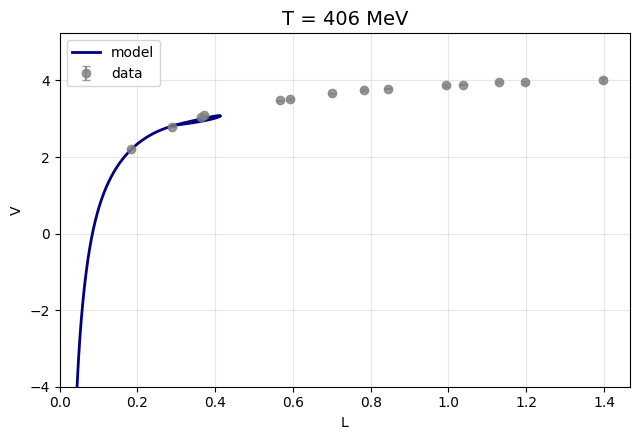

In [10]:
with torch.no_grad():
    zs = torch.linspace(0.05, 0.99, 800, dtype=dt, device=device)
    Lc = model.integrate_L(zs).real
    Vc = model.logcoef.exp() * model.integrate_V(zs).real + model.shift
    
    # Only plot the STABLE branch (before L_max where dL/dz* > 0)
    # Find where L starts decreasing
    dL = torch.diff(Lc)
    # Find the index where L reaches maximum (start of unstable branch)
    imax = torch.argmax(Lc)
    
    # Only keep the stable branch (monotonically increasing L)
    Lc_stable = Lc[:imax+1]
    Lc_unstable = Lc[imax+1:]
    Vc_stable = Vc[:imax+1]
    Vc_unstable = Vc[imax+1:]
    
    print(f"L_max = {Lc[imax].item():.4f} at z* = {zs[imax].item():.4f}")
    print(f"Stable branch: {len(Lc_stable)} points, L range: [{Lc_stable.min():.4f}, {Lc_stable.max():.4f}]")
    print(f"V range on stable branch: [{Vc_stable.min():.4f}, {Vc_stable.max():.4f}]")

plt.figure(figsize=(6.5,4.5))
plt.plot(Lc_stable.cpu(), Vc_stable.cpu(), '-',color='navy', linewidth=2, label="model")
plt.plot(Lc_unstable.cpu(), Vc_unstable.cpu(), '-', color='navy', linewidth=2)
plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(),
             yerr=dataset.sigma.real.cpu(), fmt='o', color='gray', 
             markersize=6, capsize=3, label='data', alpha=0.8)
#plt.axvline(Lc[imax].cpu(), color='green', linestyle='--', alpha=0.5, label=f'L_max={Lc[imax].item():.3f}')
plt.ylim(-4, None)
plt.xlim(0, 1.05*dataset.L.max().item())
plt.title(f"T = {T} MeV", fontsize=14)
plt.xlabel("L"); plt.ylabel("V"); plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()

**Visualization of a and b**

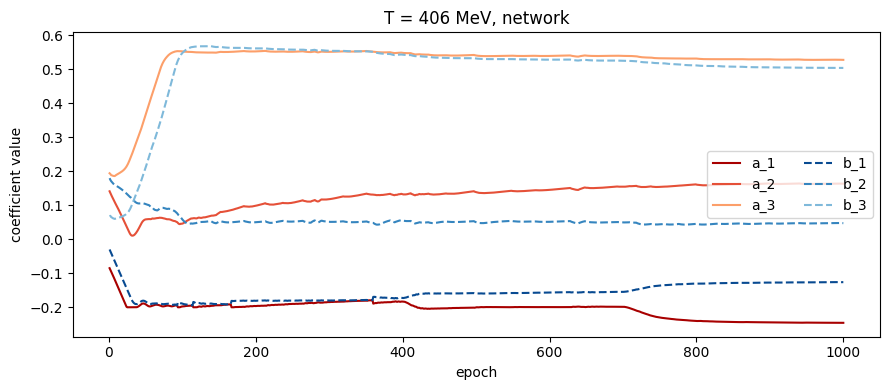

In [11]:
a_arr = np.stack(a_hist)   # shape (EPOCHS, N)
b_arr = np.stack(b_hist)   # shape (EPOCHS, N)
epochs = np.arange(1, len(a_hist)+1)

n_a = a_arr.shape[1]
n_b = b_arr.shape[1]

# palettes: darkest for index 0, lightest for highest index
warm = plt.cm.OrRd(np.linspace(0.9, 0.45, n_a))   # a: warm colors
cold = plt.cm.Blues(np.linspace(0.9, 0.45, n_b))  # b: cool colors

plt.figure(figsize=(9,4))
for i in range(n_a):
    plt.plot(epochs, a_arr[:, i], color=warm[i], label=f"a_{i+1}")
for i in range(n_b):
    plt.plot(epochs, b_arr[:, i], color=cold[i], linestyle='--', label=f"b_{i+1}")
plt.xlabel("epoch")
plt.ylabel("coefficient value")
plt.legend(ncol=2)
plt.title(f"T = {T} MeV, network")
plt.tight_layout()


# Export the results

In [12]:
def print_ab(model):
    a = model.a.detach().cpu().numpy()
    b = model.b.detach().cpu().numpy()

    # Plain readable print
    print(" T = ", T, " MeV")
    print("a:", ", ".join([f"a{i} = {a[i]:.10g}" for i in range(len(a))]))
    print("b:", ", ".join([f"b{i} = {b[i]:.10g}" for i in range(len(b))]))
    print(f"coef = {model.logcoef.exp().item():.10g}, shift = {model.shift.item():.10g}")

    # Mathematica rows
    print("\n Mathematica list (can copypaste it)")
    print("{", f"{T},", " (* Temperature in MeV *)")
    print("{", ", ".join([f"{x:.17g}" for x in a]), "},  (* a0..aN *)")
    print("{", ", ".join([f"{x:.17g}" for x in b]), "},  (* b0..bN *)")
    print(model.logcoef.exp().item(),",", model.shift.item(), " (* coef, shift *)","}")

print_ab(model)


 T =  406  MeV
a: a0 = -0.1984704842, a1 = 0.1552000139, a2 = 0.5400470385
b: b0 = -0.1545664814, b1 = 0.05094140935, b2 = 0.5256214188
coef = 0.2368930739, shift = 5.392635842

 Mathematica list (can copypaste it)
{ 406,  (* Temperature in MeV *)
{ -0.19847048424252797, 0.15520001392263796, 0.54004703848184166 },  (* a0..aN *)
{ -0.15456648143849902, 0.050941409352137104, 0.52562141883461999 },  (* b0..bN *)
0.23689307394288472 , 5.392635842205659  (* coef, shift *) }


## Test Provided Parameters (for T = 338 Mev only)

First, let's verify that the provided parameters work correctly

In [ ]:
# Test with user's provided parameters for T=338
print("Testing provided parameters...")
test_model = AdSBHNet(N=4, std=0.1)
test_model.to(device)

with torch.no_grad():
    # Set provided parameters
    a_test = [-0.29941802769769976, 0.38336158779020947, 0.50839371973445224, 0.35708662062329217]
    b_test = [-0.19941802769769976, 0.20069842426087019, 0.35202386924103916, 0.56404675790451342]

    for i in range(4):
        test_model.a[i] = a_test[i]
        test_model.b[i] = b_test[i]

    test_model.logcoef.fill_(np.log(0.21953073602142168))
    test_model.shift.fill_(5.744831414014695)

    # Quick test with fewer points for speed
    zs_test = torch.linspace(0.02, 0.99, 500, dtype=dt, device=device)
    L_test = test_model.integrate_L(zs_test).real
    V_test = test_model.logcoef.exp() * test_model.integrate_V(zs_test).real + test_model.shift

    L_max_test = L_test.max().item()
    imax_test = torch.argmax(L_test)

    print(f"\nProvided parameters results:")
    print(f"  L_max = {L_max_test:.4f} (expected ≈0.39)")
    print(f"  Constraint check:")
    print(f"    a[0] = {a_test[0]:.4f}, b[0] = {b_test[0]:.4f}")
    print(f"    a[0] < b[0] < 0? {a_test[0] < b_test[0] < 0}")
    print(f"    a[1:] > 0? {all(x > 0 for x in a_test[1:])}")
    print(f"    b[1:] > 0? {all(x > 0 for x in b_test[1:])}")

    # Plot to verify fit
    L_stable_test = L_test[:imax_test+1]
    V_stable_test = V_test[:imax_test+1]

    plt.figure(figsize=(8, 5))
    plt.plot(L_stable_test.cpu(), V_stable_test.cpu(), 'b-', linewidth=2, label='Provided params (stable)')
    plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(),
                 yerr=dataset.sigma.real.cpu(), fmt='o', color='red',
                 markersize=6, capsize=3, label='Data', alpha=0.8)
    plt.axvline(L_max_test, color='green', linestyle='--', alpha=0.5,
                label=f'L_max={L_max_test:.3f}')
    plt.xlabel('L', fontsize=12)
    plt.ylabel('V', fontsize=12)
    plt.title('Test with Provided Parameters (T=338)', fontsize=12)
    plt.legend()
    plt.ylim(-4,10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## Test with Custom Parameters

You can now easily test any parameter values:

Current trained model:


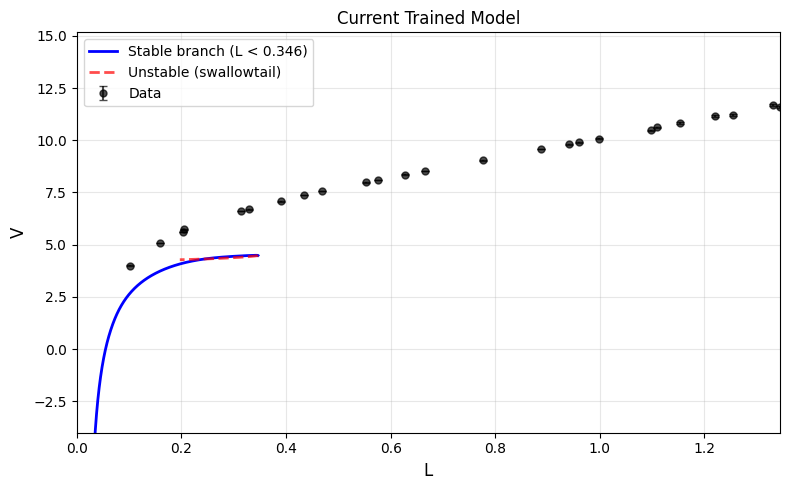

L_max = 0.3465
V(L_max) = 4.4865
a0 + b0 = 0.000000
Stable branch: 1714 points
Unstable branch: 287 points

Note: This only shows the REAL z* curve.
The complex continuation (dashed branch with Im(z*)≠0) is not computed here.


0.34645184632924086

In [12]:
def plot_model_curve(a_values, b_values, coef=1.0, shift=0.0, 
                     zmin=0.02, zmax=0.995, Nc=2000, 
                     plot_data=True, figsize=(8, 5), title=None):
    """
    Plot V vs L curve for given a and b parameters.
    
    Parameters:
    -----------
    a_values : list or array
        Coefficients [a0, a1, a2, a3, ...]
    b_values : list or array
        Coefficients [b0, b1, b2, b3, ...]
    coef : float
        Multiplicative coefficient (exp(logcoef))
    shift : float
        Additive shift to V
    zmin, zmax : float
        Range of z* to integrate over
    Nc : int
        Number of points for integration
    plot_data : bool
        Whether to overlay the dataset
    figsize : tuple
        Figure size
    title : str
        Plot title (optional)
    
    Returns:
    --------
    Lmax : float
        Maximum L value on the curve
    
    Notes:
    ------
    Physical branches:
    - STABLE: Real branch from L=0 up to L=L_max (solid blue)
    - UNSTABLE (swallowtail): Real branch from L=L_max back to smaller L (dashed red)
    
    We only compute along REAL z* here. The complex continuation would require
    integrating along complex z* paths, which is not implemented in this function.
    """
    # Create a temporary model with the given parameters
    test_model = AdSBHNet(N=len(a_values), std=0.1)
    test_model.to(device)
    
    with torch.no_grad():
        # Set parameters
        for i in range(len(a_values)):
            test_model.a[i] = a_values[i]
        for i in range(len(b_values)):
            test_model.b[i] = b_values[i]
        test_model.logcoef.fill_(np.log(coef))
        test_model.shift.fill_(shift)
        
        # Compute L and V along the parametric curve (real z* only)
        zs = torch.linspace(zmin, zmax, Nc, dtype=dt, device=device)
        Lc = test_model.integrate_L(zs).real
        # Apply coef externally (matching Mathematica)
        Vc = coef * test_model.integrate_V(zs).real + shift
        
        # Find L_max (turning point) in the unsorted data
        Lmax = Lc.max().item()
        imax = torch.argmax(Lc)
        Vmax = Vc[imax].item()
        
        # Split into two branches based on position along z*
        # Before turning point: Stable branch (L increasing with z*)
        zs_stable = zs[:imax+1]
        Lc_stable = Lc[:imax+1]
        Vc_stable = Vc[:imax+1]
        
        # After turning point: Unstable/swallowtail branch (L decreasing with z*)
        zs_unstable = zs[imax:]
        Lc_unstable = Lc[imax:]
        Vc_unstable = Vc[imax:]
    
    # Plot
    plt.figure(figsize=figsize)
    
    # Plot STABLE branch (before L_max) - solid blue
    plt.plot(Lc_stable.cpu(), Vc_stable.cpu(), 'b-', linewidth=2, 
             label=f'Stable branch (L < {Lmax:.3f})')
    
    # Plot UNSTABLE/swallowtail branch (after L_max) - dashed red
    if len(Lc_unstable) > 1:
        plt.plot(Lc_unstable.cpu(), Vc_unstable.cpu(), 'r--', linewidth=2, 
                 alpha=0.7, label='Unstable (swallowtail)')
    
    # Overlay dataset if requested
    if plot_data:
        plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(),
                     yerr=dataset.sigma.real.cpu(), fmt='o', 
                     color='black', markersize=5, capsize=3,
                     label='Data', alpha=0.7, zorder=5)
    
    plt.xlabel('L', fontsize=12)
    plt.ylabel('V', fontsize=12)
    plt.xlim(0, max(1.1*Lmax, dataset.L.max().item() if plot_data else 1.1*Lmax))
    plt.ylim(bottom=-4)
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, alpha=0.3)
    
    if title:
        plt.title(title, fontsize=12)
    else:
        plt.title(f'V(L) curve', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"L_max = {Lmax:.4f}")
    print(f"V(L_max) = {Vmax:.4f}")
    print(f"a0 + b0 = {a_values[0] + b_values[0]:.6f}")
    print(f"Stable branch: {len(Lc_stable)} points")
    print(f"Unstable branch: {len(Lc_unstable)} points")
    print("\nNote: This only shows the REAL z* curve.")
    print("The complex continuation (dashed branch with Im(z*)≠0) is not computed here.")
    
    return Lmax


# Example usage: Plot current model
print("Current trained model:")
current_a = [-0.0941803,  0.08336159, 0.0739372, 0.08662]#model.a.detach().cpu().numpy()
current_b = [ 0.0941803,  -0.07506984, -0.08202387,  -0.09404676]#model.b.detach().cpu().numpy()
current_coef = 0.2#model.logcoef.exp().item()
current_shift = 5.5#model.shift.item()

plot_model_curve(current_a, current_b, coef=current_coef, shift=current_shift,
                title="Current Trained Model")